TEM CNN

In [13]:
import os
import sys
import importlib
import pickle
import matplotlib.pyplot as plt
import numpy as np
import random
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, GaussianNoise, Dropout
from tensorflow.keras.utils import to_categorical
import pandas as pd

notebooks_dir = os.path.abspath('')
proj_dir = os.path.dirname(notebooks_dir)
raw_data_dir = os.path.join(proj_dir, 'raw_data')
src_dir = os.path.join(proj_dir, 'src')

# Add src_dir to the system path to import helper file
sys.path.insert(1, src_dir)
#import cutpaste_helper
#importlib.reload(cutpaste_helper)

def makeWindows(image_dict,num_windows, width, height):
    '''
    Parameters:
    image_dict: dictionary containing arrays that represent images
    num_windows: the number of windows wanted
    width: the width of the window
    height: the height of the window
    '''
    
    #store the coordinates of the defective window
    
    #Grab windows from the full images from train images
    window_images = []
    for key in image_dict:
    #The 100 windows per image in a list
        for i in range(0, num_windows):
            #Get the width and height of an image
            dimensions = image_dict[key].shape
            image_w = dimensions[1]
            image_h = dimensions[0]
            #Random coordinates
            random_x_coord = random.randint(0, image_w - width)
            random_y_coord = random.randint(0, image_h-height)
            #Takes window out of a random part of the images at the random coordinates
            window = image_dict[key][random_y_coord:random_y_coord + window_y, random_x_coord:random_x_coord + window_x]
            window_images.append(window)
    window_images = np.array(window_images)
    return window_images

def makeWhiteSquares(window_list):
    #Create test window images dict with white square defects
    defect_window_list = np.copy(window_list)
#Fill defect train window images
    for image in defect_window_list:
        #Random sized white square (2D array full of ones)
        sq_random_x = random.randint(5,25)
        sq_random_y = random.randint(5,25)
        white_square = np.ones((sq_random_y,sq_random_x))
        #Random coordinates for the square
        random_x_coord = random.randint(0,window_x-sq_random_x)
        random_y_coord = random.randint(0,window_y-sq_random_y)
        #Replace the coordinates with white square
        image[random_y_coord:random_y_coord + sq_random_y, random_x_coord: random_x_coord + sq_random_x,0] = white_square
    return defect_window_list

def copyPaste(image):
    copied_image = np.copy(image)
    #Random sized copy-pasted area (2D array)
    sq_random_x = random.randint(5,25)
    sq_random_y = random.randint(5,25)
    #Random coordinates for the square
    random_x_coord = random.randint(0,image.shape[1]-sq_random_x)
    random_y_coord = random.randint(0,image.shape[0]-sq_random_y)
    #Copy the area
    copyArea = image[random_y_coord:random_y_coord + sq_random_y, random_x_coord: random_x_coord + sq_random_x,0]
    #Paste coordinates
    random_x_coord = random.randint(0,window_x-sq_random_x)
    random_y_coord = random.randint(0,window_y-sq_random_y)
    #Paste the area
    copied_image[random_y_coord:random_y_coord + sq_random_y, random_x_coord: random_x_coord + sq_random_x,0] = copyArea
    return copied_image

def createLabels(image_list, defect_status):
    #Create labels for the images
    labels_list = []
    for image in image_list:
        if defect_status:
            labels_list.append(1)
        else:
            labels_list.append(0)
    labels_list = np.array(labels_list)
    return labels_list
        
def shuffleTwoArrays(image_list, label_list):
    #Shuffles the image and label arrays in the same way
    randomize = np.arange(len(label_list))
    np.random.shuffle(randomize)
    image_list = image_list[randomize]
    label_list = label_list[randomize]
    return (image_list, label_list)

def generateImages(normal_image_list, num_normal, num_defects):
    #A generator that generates images
    while True:
        generated_images = []
        generated_labels = []
        for i in range(num_normal):
            random_index = random.randint(0,len(normal_image_list)-1)
            generated_images.append(normal_image_list[random_index])
            generated_labels.append(0)
        for i in range(num_defects):
            random_index = random.randint(0,len(normal_image_list)-1)
            generated_images.append(copyPaste(normal_image_list[random_index]))
            generated_labels.append(1)
        generated_images = np.array(generated_images)
        generated_labels = np.array(generated_labels)
        generated_images, generated_labels = shuffleTwoArrays(generated_images, generated_labels)
        n = generated_images.shape[0]
        yield generated_images, generated_labels.reshape(n, 1)

def valGeneratorImages(test_x, test_y, num_desired):
    while True:
        generated_images = []
        generated_labels = []
        for i in range(num_normal):
            random_index = random.randint(0,len(test_x)-1)
            generated_images.append(test_x[random_index])
            generated_labels.append(test_y[random_index])
        yield generated_images, generated_labels

# Load dictionaries with TEM images
f_name = os.path.join(raw_data_dir, 'test_full_arrays')
#Dict with test image arrays (each key has a value of an array of numbers between 0 and 1)
test_full_arrays = pickle.load(open(f_name, "rb"))
f_name = os.path.join(raw_data_dir, 'train_full_arrays')
#Dict with train image arrays (each key has a value of an array of numbers between 0 and 1)
train_full_arrays = pickle.load(open(f_name, "rb"))

window_x = 118
window_y = 84
num_windows = 100

#Make testing window images and labels
test_window_images = makeWindows(test_full_arrays, num_windows, window_x, window_y)
test_window_labels = createLabels(test_window_images, False)

#Make training window images and labels
train_window_images = makeWindows(train_full_arrays, num_windows ,window_x, window_y)
train_window_labels = createLabels(train_window_images, False)

#Stuff
filters = 16
filter_size = 3
pool_size = 2
epoch_number = 1
my_models = []
my_val_accuracy = []
my_val_loss = []
model_layers = ["5_layers", "7_layers", "10_layers"]

# Build the model.
for i in range(len(model_layers)):
    train_gen = generateImages(train_window_images, 64, 64)
    val_gen = generateImages(test_window_images, 32, 32)
    print(f'{filters} Filters Results: ')
    model = Sequential([
      Conv2D(filters, filter_size), 
      MaxPooling2D(pool_size = pool_size), 
      Conv2D(filters * 2, filter_size),
      Dropout(.2),
      Conv2D(filters * 4, filter_size),
      MaxPooling2D(pool_size = pool_size), 
      Conv2D(filters * 6, filter_size),
      Dropout(.2) ,
      Conv2D(filters * 8, filter_size),
      MaxPooling2D(pool_size = pool_size), 
    ])
    if i > 0:
        model.add(Conv2D(filters * 10, filter_size))
        model.add(MaxPooling2D(pool_size = pool_size))
        model.add(Conv2D(filters * 12, filter_size))
        model.add(MaxPooling2D(pool_size = pool_size))
    if i > 1:
        model.add(Conv2D(filters * 14, filter_size))
        model.add(MaxPooling2D(pool_size = pool_size))
        model.add(Conv2D(filters * 16, filter_size))
        model.add(MaxPooling2D(pool_size = pool_size))
        model.add(Conv2D(filters * 18, filter_size))
        model.add(MaxPooling2D(pool_size = pool_size))
    model.add(Flatten())
    model.add(Dense(2, activation = 'softmax'))

    # Compile the model.
    model.compile(
      'adam',
      loss='binary_crossentropy',
      metrics=['accuracy'],
    )

    # Train the model.
    history = model.fit(
      train_gen,
      validation_data = val_gen,
      epochs = epoch_number,
      steps_per_epoch=11200/64,
      validation_steps = 11200/64
    )
    
    my_models.append(model)
    my_val_accuracy.append(history.history['val_accuracy'][-1])
    my_val_loss.append(history.history['val_loss'][-1])
    
    
    # Predict on the first 5 test images.
    predictions = model.predict(test_window_images[:5])

    # Print our model's predictions.
    print("Predictions")
    print(np.argmax(predictions, axis=1))

    # Check our predictions against the ground truths.
    print("Real Labels")
    print(test_window_labels[:5])
    
    #Saves the models and model metrics to a dataframe, then saves the dataframe to a csv file and a excel file
    d = {'Models' : my_models, 'Value Accuracy' : my_val_accuracy, 'Value Loss' : my_val_loss, "Filters" : filters}
    df = pd.DataFrame(data=d, index = model_layers)
    df.to_csv(r'C:\Users\songa\Cutpaste Work\project_cutpaste\CSV files\{model_layers[i]}', index=False)
    df.to_excel(r'C:\Users\songa\Cutpaste Work\project_cutpaste\CSV files\{model_layers[i]}.xlsx', index=False)
    display(df)
    
#     FIGURE = i
#     plt.figure(FIGURE)
#     plt.plot(history.history['accuracy'], 'g', label = "Train Accuracy")
#     plt.plot(history.history['val_accuracy'], 'b', label = "Test Accuracy")
#     plt.title("Training Accuracy and Test Accuracy")
#     plt.xlabel("Accuracy")
#     plt.ylabel("Epochs")
#     plt.legend(loc = "upper left")
#     plt.show

#     plt.plot(history.history['loss'],'g', label = "Training loss")
#     plt.plot(history.history['val_loss'], 'b', label = "Test loss")
#     plt.title("Training Loss and Test Loss")
#     plt.xlabel("Loss")
#     plt.ylabel("Epochs")
#     plt.legend(loc = "upper left")
#     plt.show


16 Filters Results: 
1/1 [==============================] - 0s 294ms/step
Predictions
[1 1 1 0 1]
Real Labels
[0 0 0 0 0]


,Models,Value Accuracy,Value Loss,Filters
5_layers,<keras.engine.sequential.Sequential object at ...,0.403929,0.685613,16
7_layers,<keras.engine.sequential.Sequential object at ...,0.403929,0.685613,16
10_layers,<keras.engine.sequential.Sequential object at ...,0.403929,0.685613,16


16 Filters Results: 


InternalError: Graph execution error:

Detected at node 'gradient_tape/sequential_13/conv2d_79/Conv2D/Conv2DBackpropInput' defined at (most recent call last):
    File "C:\Users\songa\anaconda3\lib\runpy.py", line 197, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "C:\Users\songa\anaconda3\lib\runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "C:\Users\songa\anaconda3\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
      app.launch_new_instance()
    File "C:\Users\songa\anaconda3\lib\site-packages\traitlets\config\application.py", line 846, in launch_instance
      app.start()
    File "C:\Users\songa\anaconda3\lib\site-packages\ipykernel\kernelapp.py", line 677, in start
      self.io_loop.start()
    File "C:\Users\songa\anaconda3\lib\site-packages\tornado\platform\asyncio.py", line 199, in start
      self.asyncio_loop.run_forever()
    File "C:\Users\songa\anaconda3\lib\asyncio\base_events.py", line 601, in run_forever
      self._run_once()
    File "C:\Users\songa\anaconda3\lib\asyncio\base_events.py", line 1905, in _run_once
      handle._run()
    File "C:\Users\songa\anaconda3\lib\asyncio\events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "C:\Users\songa\anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 471, in dispatch_queue
      await self.process_one()
    File "C:\Users\songa\anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 460, in process_one
      await dispatch(*args)
    File "C:\Users\songa\anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 367, in dispatch_shell
      await result
    File "C:\Users\songa\anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 662, in execute_request
      reply_content = await reply_content
    File "C:\Users\songa\anaconda3\lib\site-packages\ipykernel\ipkernel.py", line 360, in do_execute
      res = shell.run_cell(code, store_history=store_history, silent=silent)
    File "C:\Users\songa\anaconda3\lib\site-packages\ipykernel\zmqshell.py", line 532, in run_cell
      return super().run_cell(*args, **kwargs)
    File "C:\Users\songa\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2863, in run_cell
      result = self._run_cell(
    File "C:\Users\songa\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2909, in _run_cell
      return runner(coro)
    File "C:\Users\songa\anaconda3\lib\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "C:\Users\songa\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3106, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "C:\Users\songa\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3309, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "C:\Users\songa\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3369, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\songa\AppData\Local\Temp\ipykernel_11168\3174079618.py", line 203, in <cell line: 164>
      history = model.fit(
    File "C:\Users\songa\anaconda3\lib\site-packages\keras\utils\traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\songa\anaconda3\lib\site-packages\keras\engine\training.py", line 1409, in fit
      tmp_logs = self.train_function(iterator)
    File "C:\Users\songa\anaconda3\lib\site-packages\keras\engine\training.py", line 1051, in train_function
      return step_function(self, iterator)
    File "C:\Users\songa\anaconda3\lib\site-packages\keras\engine\training.py", line 1040, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\songa\anaconda3\lib\site-packages\keras\engine\training.py", line 1030, in run_step
      outputs = model.train_step(data)
    File "C:\Users\songa\anaconda3\lib\site-packages\keras\engine\training.py", line 893, in train_step
      self.optimizer.minimize(loss, self.trainable_variables, tape=tape)
    File "C:\Users\songa\anaconda3\lib\site-packages\keras\optimizers\optimizer_v2\optimizer_v2.py", line 537, in minimize
      grads_and_vars = self._compute_gradients(
    File "C:\Users\songa\anaconda3\lib\site-packages\keras\optimizers\optimizer_v2\optimizer_v2.py", line 590, in _compute_gradients
      grads_and_vars = self._get_gradients(tape, loss, var_list, grad_loss)
    File "C:\Users\songa\anaconda3\lib\site-packages\keras\optimizers\optimizer_v2\optimizer_v2.py", line 471, in _get_gradients
      grads = tape.gradient(loss, var_list, grad_loss)
Node: 'gradient_tape/sequential_13/conv2d_79/Conv2D/Conv2DBackpropInput'
Failed to call dnnl_sgemm. Error code: 2
	 [[{{node gradient_tape/sequential_13/conv2d_79/Conv2D/Conv2DBackpropInput}}]] [Op:__inference_train_function_32075]

In [34]:
x,y = next(train_gen)
print(type(x))
print(type(y))

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


In [7]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

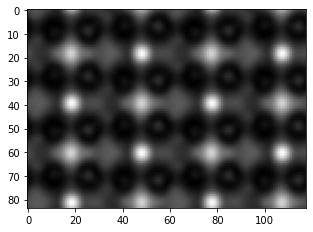

In [13]:
my_array = test_window_images[60]
plt.figure(figsize=(5,5))
plt.imshow(my_array, cmap='gray')
plt.show()

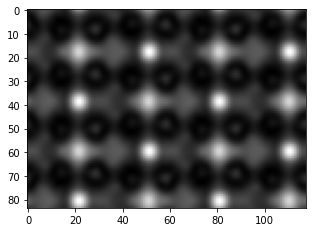

In [14]:
my_array = test_window_images[20]
plt.figure(figsize=(5,5))
plt.imshow(my_array, cmap='gray')
plt.show()

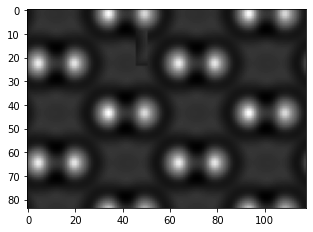

In [15]:
my_array = images[60]
plt.figure(figsize=(5,5))
plt.imshow(my_array, cmap='gray')
plt.show()

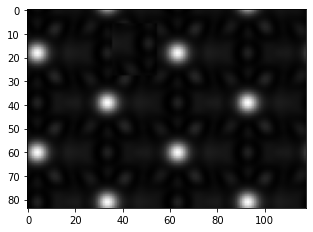

In [16]:
my_array = images[20]
plt.figure(figsize=(5,5))
plt.imshow(my_array, cmap='gray')
plt.show()

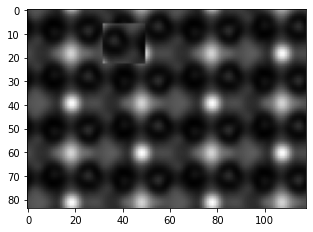

In [18]:
my_array = defect_test_window_images[60]
plt.figure(figsize=(5,5))
plt.imshow(my_array, cmap='gray')
plt.show()

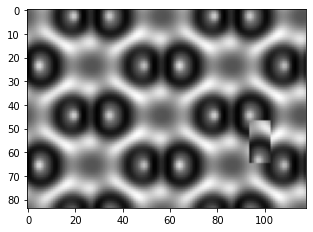

In [17]:
my_array = defect_train_window_images[60]
plt.figure(figsize=(5,5))
plt.imshow(my_array, cmap='gray')
plt.show()

In [15]:
test_full_arrays.keys()

dict_keys(['GaAs_10nm_002', 'GaAs_10nm_017', 'GaAs_10nm_014', 'GaAs_10nm_011', 'GaAs_10nm_005', 'GaAs_10nm_008', 'GaAs_10nm_020', 'GaAs_1nm_011', 'GaAs_1nm_005', 'GaAs_1nm_014', 'GaAs_1nm_002', 'GaAs_1nm_017', 'GaAs_1nm_020', 'GaAs_1nm_008', 'GaAs_6nm_014', 'GaAs_6nm_017', 'GaAs_6nm_002', 'GaAs_6nm_011', 'GaAs_6nm_005', 'GaAs_6nm_020', 'GaAs_6nm_008', 'GaAs_2nm_008', 'GaAs_2nm_020', 'GaAs_2nm_011', 'GaAs_2nm_005', 'GaAs_2nm_014', 'GaAs_2nm_017', 'GaAs_2nm_002', 'GaAs_8nm_020', 'GaAs_8nm_008', 'GaAs_8nm_002', 'GaAs_8nm_017', 'GaAs_8nm_014', 'GaAs_8nm_005', 'GaAs_8nm_011', 'GaAs_12nm_008', 'GaAs_12nm_020', 'GaAs_12nm_017', 'GaAs_12nm_002', 'GaAs_12nm_014', 'GaAs_12nm_011', 'GaAs_12nm_005', 'GaAs_4nm_020', 'GaAs_4nm_008', 'GaAs_4nm_014', 'GaAs_4nm_002', 'GaAs_4nm_017', 'GaAs_4nm_011', 'GaAs_4nm_005', 'GaAs_15nm_008', 'GaAs_15nm_020', 'GaAs_15nm_011', 'GaAs_15nm_005', 'GaAs_15nm_002', 'GaAs_15nm_017', 'GaAs_15nm_014'])

In [16]:
train_full_arrays.keys()

dict_keys(['GaAs_10nm_016', 'GaAs_10nm_003', 'GaAs_10nm_001', 'GaAs_10nm_015', 'GaAs_10nm_004', 'GaAs_10nm_010', 'GaAs_10nm_013', 'GaAs_10nm_007', 'GaAs_10nm_006', 'GaAs_10nm_012', 'GaAs_10nm_021', 'GaAs_10nm_009', 'GaAs_10nm_019', 'GaAs_10nm_018', 'GaAs_1nm_013', 'GaAs_1nm_007', 'GaAs_1nm_006', 'GaAs_1nm_012', 'GaAs_1nm_004', 'GaAs_1nm_010', 'GaAs_1nm_001', 'GaAs_1nm_015', 'GaAs_1nm_016', 'GaAs_1nm_003', 'GaAs_1nm_019', 'GaAs_1nm_018', 'GaAs_1nm_009', 'GaAs_1nm_021', 'GaAs_6nm_001', 'GaAs_6nm_015', 'GaAs_6nm_003', 'GaAs_6nm_016', 'GaAs_6nm_006', 'GaAs_6nm_012', 'GaAs_6nm_013', 'GaAs_6nm_007', 'GaAs_6nm_004', 'GaAs_6nm_010', 'GaAs_6nm_009', 'GaAs_6nm_021', 'GaAs_6nm_018', 'GaAs_6nm_019', 'GaAs_2nm_018', 'GaAs_2nm_019', 'GaAs_2nm_021', 'GaAs_2nm_009', 'GaAs_2nm_006', 'GaAs_2nm_012', 'GaAs_2nm_013', 'GaAs_2nm_007', 'GaAs_2nm_004', 'GaAs_2nm_010', 'GaAs_2nm_001', 'GaAs_2nm_015', 'GaAs_2nm_003', 'GaAs_2nm_016', 'GaAs_8nm_009', 'GaAs_8nm_021', 'GaAs_8nm_019', 'GaAs_8nm_018', 'GaAs_8nm_016',